<a href="https://colab.research.google.com/github/fabricejumel/FNST_google_collab_training/blob/main/facestyliser/Test_group_Mediapipe_styliser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install mediapipe opencv-python matplotlib -q

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import urllib.request

# Télécharge modèle color sketch
urllib.request.urlretrieve(
    'https://storage.googleapis.com/mediapipe-models/face_stylizer/blaze_face_stylizer/float32/latest/face_stylizer_color_sketch.task',
    'group_style.task'
)

BaseOptions = python.BaseOptions
FaceStylizer = vision.FaceStylizer
FaceStylizerOptions = vision.FaceStylizerOptions

print("✅ Setup OK → Cellule 2")


✅ Setup OK → Cellule 2


👥 UPLOAD PHOTO GROUPE:


Saving test_16.jpg to test_16 (1).jpg
📏 660x370
🎯 3 visages détectés → Cellule 3


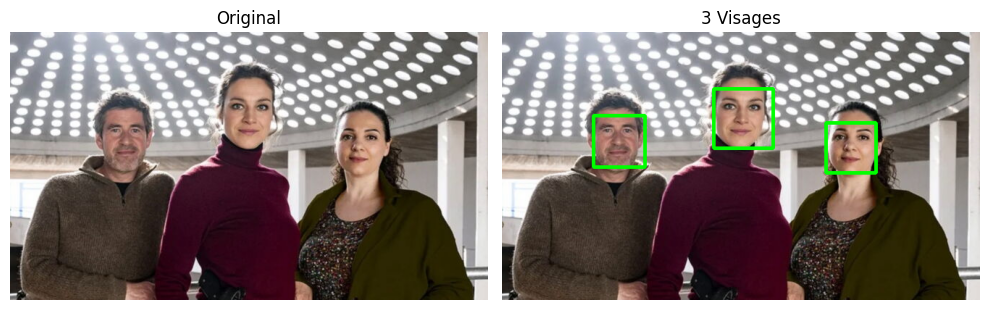

In [6]:
print("👥 UPLOAD PHOTO GROUPE:")
uploaded = files.upload()
group_filename = list(uploaded.keys())[0]

# CHARGEMENT
group_image = cv2.imread(group_filename)
group_rgb = cv2.cvtColor(group_image, cv2.COLOR_BGR2RGB)
h, w = group_image.shape[:2]
print(f"📏 {w}x{h}")

# DÉTECTION VISAGES
face_detector = mp.solutions.face_detection
with face_detector.FaceDetection(model_selection=1, min_detection_confidence=0.5) as detector:
    results = detector.process(cv2.cvtColor(group_image, cv2.COLOR_BGR2RGB))

    if not results.detections:
        print("❌ Aucun visage détecté")
        plt.imshow(group_rgb); plt.axis('off'); plt.show()
    else:
        faces = []
        for detection in results.detections:
            bbox = detection.location_data.relative_bounding_box
            x, y = int(bbox.xmin * w), int(bbox.ymin * h)
            fw, fh = int(bbox.width * w), int(bbox.height * h)
            faces.append((x, y, x+fw, y+fh))

        print(f"🎯 {len(faces)} visages détectés → Cellule 3")

        # PREVIEW BOÎTES VERTES
        det_img = group_rgb.copy()
        for (x1,y1,x2,y2) in faces:
            cv2.rectangle(det_img, (x1,y1), (x2,y2), (0,255,0), 3)

        plt.figure(figsize=(10,6))
        plt.subplot(121); plt.imshow(group_rgb); plt.title('Original'); plt.axis('off')
        plt.subplot(122); plt.imshow(det_img); plt.title(f'{len(faces)} Visages'); plt.axis('off')
        plt.tight_layout(); plt.show()


🎨 STYLISATION + COLLAGE PADDING CORRECT (Visages +25%)...
  Visage 1/3 bbox: 82x82
     → COLLAGE padding: 123x123 (+25%)
  Visage 2/3 bbox: 69x69
     → COLLAGE padding: 104x104 (+25%)
  Visage 3/3 bbox: 71x71
     → COLLAGE padding: 106x106 (+25%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

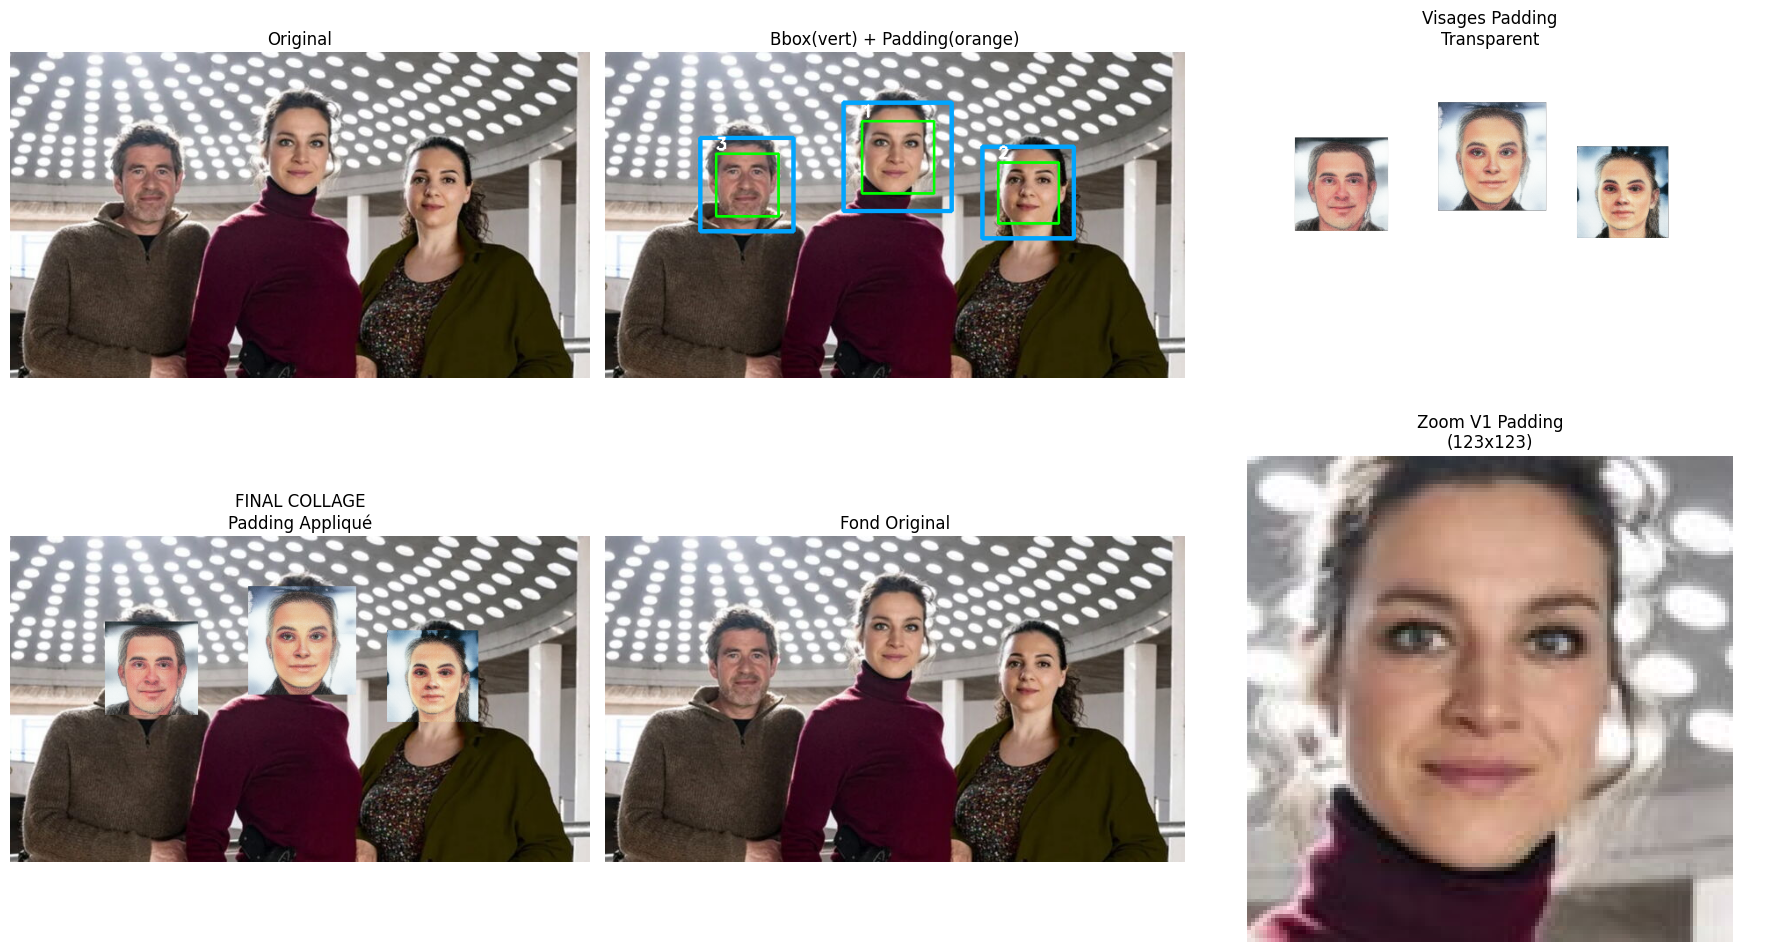

✅ COLLAGE PADDING 25% | final_collage.png prêt !


In [15]:
print("🎨 STYLISATION + COLLAGE PADDING CORRECT (Visages +25%)...")
base_options = BaseOptions(model_asset_path='group_style.task', delegate=BaseOptions.Delegate.CPU)
options = FaceStylizerOptions(base_options=base_options)

styled_faces = np.zeros((h, w, 4), dtype=np.uint8)
final_collage = cv2.cvtColor(group_image, cv2.COLOR_BGR2RGBA)

with FaceStylizer.create_from_options(options) as stylizer:
    for i, (x1, y1, x2, y2) in enumerate(faces):
        bbox_w, bbox_h = x2-x1, y2-y1
        print(f"  Visage {i+1}/{len(faces)} bbox: {bbox_w}x{bbox_h}")

        # PADDING UNE FOIS (fix !)
        pad = 0.25
        px1 = max(0, int(x1 - pad*bbox_w))
        py1 = max(0, int(y1 - pad*bbox_h))
        px2 = min(w, int(x2 + pad*bbox_w))
        py2 = min(h, int(y2 + pad*bbox_h))
        pad_w, pad_h = px2-px1, py2-py1

        print(f"     → COLLAGE padding: {pad_w}x{pad_h} (+{pad*100:.0f}%)")

        # CROP + STYLE
        face_crop = group_image[py1:py2, px1:px2]
        if face_crop.size == 0: continue

        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=face_rgb)
        styled_face_rgb = stylizer.stylize(mp_image).numpy_view()

        # RESIZE à PADDING (plus grand !)
        styled_resized = cv2.resize(styled_face_rgb, (pad_w, pad_h))
        styled_rgba = np.zeros((pad_h, pad_w, 4), dtype=np.uint8)
        styled_rgba[:, :, :3] = styled_resized
        styled_rgba[:, :, 3] = 255

        # ✅ COLLAGE sur PADDING (pas bbox !)
        styled_faces[py1:py2, px1:px2] = styled_rgba
        final_collage[py1:py2, px1:px2] = styled_rgba

# DOWNLOAD
cv2.imwrite('faces_stylized.png', styled_faces)
cv2.imwrite('final_collage.png', final_collage)
cv2.imwrite('background_only.jpg', group_image)
files.download('faces_stylized.png')
files.download('final_collage.png')
files.download('background_only.jpg')

# PREVIEW avec MESURE
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original
axes[0,0].imshow(group_rgb); axes[0,0].set_title('Original'); axes[0,0].axis('off')

# Bbox + Padding (mesure !)
debug_img = group_rgb.copy()
for j, (x1,y1,x2,y2) in enumerate(faces):
    pad = 0.25
    px1 = max(0, int(x1-pad*(x2-x1)))
    py1 = max(0, int(y1-pad*(y2-y1)))
    px2 = min(w, int(x2+pad*(x2-x1)))
    py2 = min(h, int(y2+pad*(y2-y1)))
    cv2.rectangle(debug_img, (x1,y1), (x2,y2), (0,255,0), 2)  # Vert=bbox
    cv2.rectangle(debug_img, (px1,py1), (px2,py2), (0,165,255), 4)  # Orange=PADDING
    cv2.putText(debug_img, f'{j+1}', (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
axes[0,1].imshow(debug_img); axes[0,1].set_title('Bbox(vert) + Padding(orange)'); axes[0,1].axis('off')

# Transparent
axes[0,2].imshow(styled_faces); axes[0,2].set_title('Visages Padding\nTransparent'); axes[0,2].axis('off')

# Final collage
axes[1,0].imshow(final_collage); axes[1,0].set_title('FINAL COLLAGE\nPadding Appliqué'); axes[1,0].axis('off')

# Background
axes[1,1].imshow(group_rgb); axes[1,1].set_title('Fond Original'); axes[1,1].axis('off')

# Zoom 1er visage (preuve !)
if faces:
    x1,y1,x2,y2 = faces[0]
    pad = 0.25
    px1,py1 = max(0,int(x1-pad*(x2-x1))), max(0,int(y1-pad*(y2-y1)))
    px2,py2 = min(w,int(x2+pad*(x2-x1))), min(h,int(y2+pad*(y2-y1)))
    zoom = group_image[py1:py2, px1:px2]
    axes[1,2].imshow(cv2.cvtColor(zoom, cv2.COLOR_BGR2RGB));
    axes[1,2].set_title(f'Zoom V1 Padding\n({px2-px1}x{py2-py1})'); axes[1,2].axis('off')

plt.tight_layout(); plt.show()
print(f"✅ COLLAGE PADDING {pad*100:.0f}% | final_collage.png prêt !")
